# Exploring parameters

#### density plots, post predictive checks etc.

In [24]:
%load_ext autoreload
%autoreload 2
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole


import sys
sys.path.append('../code/')
sys.path.append('../code/utils/')
#sys.path.append('../code/sbi/')
#sys.path.append('../../results_cluster/')


import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt


import os

work_dir = '/home/ubuntu/sbi_for_eeg_data/code/'

os.chdir(work_dir)

#from utils.plot import cov, compare_vars, plot_varchanges
#from utils.plot import compare_KLs, plot_KLs
#from sbi.inference import potentials
import utils.sbi_modulated_functions

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

from sbi.analysis import conditional_pairplot, conditional_corrcoeff



# import the summary statistics that you want to investigate
from summary_features.calculate_summary_features import calculate_summary_statistics_alternative as alternative_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal as temporal_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_number as number_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
print(torch.__version__)

1.11.0


In [26]:
## defining neuronal network model

num_params = 6

from utils.simulation_wrapper import set_network_default, SimulationWrapper
sim_wrapper = SimulationWrapper(num_params, noise=False)


In [29]:
from utils import inference

import pickle
from data_load_writer import *
from data_load_writer import load_from_file as lf

import os

work_dir = '/home/ubuntu/'

os.chdir(work_dir)



import os

print(os.getcwd())


file = 'toy_example_maf_29_04_noratio_more_sims2'

#file = 'toy_example_mdn_05_04_no_ratio'


print(os.getcwd())

os.chdir('results/{}'.format(file))


print(os.getcwd())
  



/home/ubuntu
/home/ubuntu
/home/ubuntu/results/toy_example_maf_29_04_noratio_more_sims2


In [30]:
def Gaussian(thetas, normal_noise=1):
    
    gauss_list = []
    
    for theta in thetas:
    
        mu, sigma = theta, normal_noise # mean and standard deviation

        s = np.random.normal(mu, sigma, 1)
    
        
        gauss_list.append(s[0])
        
    gauss_obs = torch.tensor(gauss_list)
    
    return gauss_obs
    



In [34]:
list_collection = torch.load('list_collection.pt')
list_collection_inc = torch.load('list_collection_inc.pt')

In [35]:
true_thetas = torch.tensor([[3.0, 6.0, 20.0, 10.0, 90.0, 55.0, 27.0, 27.0, 4.0, 70.0, 5.0, 66.0, 99.0, 40.0, 45.0]])
parameter_names = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15']

prior_max = [100.0] * 15
prior_min = [1.0] * 15

prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)

samples_prior = prior.sample((10000,))

simulator_stats, prior = prepare_for_sbi(Gaussian, prior)

In [36]:
samples_prior_list = samples_prior.unsqueeze(0)

In [37]:
samples_prior_list[0].shape

torch.Size([10000, 15])

In [38]:
thetas = inference.run_only_sim(samples_prior_list, simulation_wrapper = simulator_stats, num_workers=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished


In [39]:
def KL_Gauss(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)

    var_y = Y.stddev

    mu_y = Y.mean
    
    
    return torch.mean(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)), var_x, mu_x


def calc_KL_1d(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)
    
    print(var_x)
    print(mu_x)


    var_y = Y.stddev

    mu_y = Y.mean
    
    print(mu_y)
    print(var_y)
    
    print(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2))
    
    return np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)


# calculate the jensen-shanon divergence
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [40]:

analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_snpe_list = []

variance_list_snpe = []

mean_list_snpe = []


## for round
for posterior_snpe_list in list_collection:
    
    KL_snpe = []
    KL_snpe_1d = []
    
    
    ## for number of simulations
    for posterior_snpe in posterior_snpe_list:


        #KL = KLdivergence(posterior_snpe, sample_y)
        KL, var_x, mu_x = KL_Gauss(posterior_snpe, analytic)
        
        variance_list_snpe.append(var_x)
        
        mean_list_snpe.append(mu_x)


        KL_1d = calc_KL_1d(posterior_snpe, analytic)

        KL_snpe_1d.append(KL_1d)

        #KL_snpe_sum.append(sum_KL)

        KL_snpe.append(KL)
        
    overall_snpe_list.append(KL_snpe)


    
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.008


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 910 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.008181818181818182
acceptance rate:  0.008
acceptance rate:  0.008387096774193548
acceptance rate:  0.00826829268292683
acceptance rate:  0.007941176470588234
acceptance rate:  0.00798360655737705
acceptance rate:  0.008295774647887324
acceptance rate:  0.008481481481481482
acceptance rate:  0.008648351648351649
acceptance rate:  0.008722772277227724
acceptance rate:  0.008882882882882883
acceptance rate:  0.008826446280991735


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.011


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 907 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.008454545454545454
acceptance rate:  0.008142857142857143
acceptance rate:  0.008193548387096775
acceptance rate:  0.008
acceptance rate:  0.00823529411764706
acceptance rate:  0.008163934426229508
acceptance rate:  0.008253521126760564
acceptance rate:  0.00817283950617284
acceptance rate:  0.008318681318681319
acceptance rate:  0.008326732673267327
acceptance rate:  0.008432432432432432
acceptance rate:  0.008462809917355372
tensor([4.1667, 5.1757, 4.4046, 4.6236, 6.1104, 3.1006, 5.2970, 3.6965, 3.3574,
        4.2310, 4.7916, 3.1716, 4.3949, 2.8273, 3.1562])
tensor([ 6.6151,  8.4537, 22.1920,  9.5611, 88.4630, 52.5017, 33.1175, 30.3870,
         5.2096, 70.1200, 10.3971, 65.4472, 93.8171, 41.7707, 46.3499])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[13.2882, 14.2603, 10.1199,  8.7542, 17.5397,  6.2959, 30.5741, 10.7607,
          4.6

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.009


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 942 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.005272727272727273
acceptance rate:  0.005714285714285714
acceptance rate:  0.005354838709677419
acceptance rate:  0.005731707317073171
acceptance rate:  0.005705882352941176
acceptance rate:  0.005655737704918033
acceptance rate:  0.005591549295774648
acceptance rate:  0.005703703703703704
acceptance rate:  0.005538461538461538
acceptance rate:  0.005722772277227723
acceptance rate:  0.00563063063063063
acceptance rate:  0.0054958677685950415
acceptance rate:  0.005366412213740458
acceptance rate:  0.005375886524822695
acceptance rate:  0.005357615894039735
acceptance rate:  0.005360248447204969
acceptance rate:  0.005403508771929824
acceptance rate:  0.00530939226519337
acceptance rate:  0.005293193717277487


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.002


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 943 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0051818181818181815
acceptance rate:  0.004904761904761905
acceptance rate:  0.0049354838709677416
acceptance rate:  0.005048780487804878
acceptance rate:  0.005
acceptance rate:  0.0051639344262295085
acceptance rate:  0.005295774647887324
acceptance rate:  0.005358024691358025
acceptance rate:  0.00532967032967033
acceptance rate:  0.005257425742574258
acceptance rate:  0.0051981981981981985
acceptance rate:  0.005289256198347108
acceptance rate:  0.0053129770992366415
acceptance rate:  0.005312056737588652
acceptance rate:  0.005317880794701987
acceptance rate:  0.005329192546583851
acceptance rate:  0.005333333333333333
acceptance rate:  0.005342541436464088
acceptance rate:  0.005308900523560209
tensor([5.7604, 3.0959, 4.2396, 4.3775, 4.9540, 2.0716, 3.3292, 3.2254, 6.9734,
        3.4119, 4.2786, 3.6635, 4.1040, 1.7481, 2.7315])
tensor([10.5965,  7.1304, 20.4545, 10.8163, 86.6154, 54.1897, 28.3201, 28.3267,
        10.1666, 68.6679,  6.5581, 63.3596, 94.6770, 

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.339
acceptance rate:  0.3256363636363636


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.303
acceptance rate:  0.32427272727272727
tensor([4.3388, 3.9618, 3.6922, 5.4348, 3.5517, 3.0150, 2.7611, 2.9486, 3.8309,
        2.1153, 3.5498, 3.1240, 2.8631, 2.3195, 2.4289])
tensor([ 9.1060,  7.9573, 23.4445, 18.3569, 84.8752, 52.2346, 31.7156, 29.6388,
        10.4660, 67.5867,  7.1553, 61.6683, 96.2458, 39.7270, 45.5334])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[26.0863,  7.8868, 10.9423, 47.4948, 17.6716,  6.7652, 13.4147,  6.2475,
         26.3993,  3.9000,  6.8562, 12.6224,  6.3397,  1.3859,  1.7046]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.111
acceptance rate:  0.106


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.11
acceptance rate:  0.1149090909090909
tensor([5.5011, 3.7719, 3.4924, 4.7291, 3.9806, 2.3661, 2.8243, 3.2939, 6.4213,
        3.9396, 5.2415, 2.5568, 3.1740, 3.4117, 2.3556])
tensor([14.0697, 12.6969, 23.8018, 14.1104, 86.3384, 56.5955, 27.9277, 27.2138,
        17.4136, 63.9578, 10.2357, 64.9243, 96.1788, 44.6843, 45.2017])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 74.1954,  27.7102,  11.5747,  17.5762,  12.7448,   2.7108,   2.8803,
           3.7555, 108.2197,  24.1433,  25.2860,   2.4084,   7.3618,  15.0641,
           1.4380]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.015
acceptance rate:  0.028363636363636365
acceptance rate:  0.02880952380952381
acceptance rate:  0.02829032258064516
acceptance rate:  0.028219512195121952


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.042
acceptance rate:  0.027545454545454547
acceptance rate:  0.027666666666666666
acceptance rate:  0.028129032258064516
acceptance rate:  0.02726829268292683
tensor([3.9442, 2.2802, 3.0009, 3.3586, 3.3060, 1.5550, 2.3740, 2.9454, 3.1845,
        2.3584, 3.9548, 2.4257, 2.7807, 1.9619, 2.1104])
tensor([ 7.7527,  3.9048, 18.2157, 16.4392, 88.0529, 55.8568, 30.7015, 27.8587,
         6.9126, 65.2186, 10.5086, 63.3931, 96.4219, 38.7171, 45.2532])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[17.2003,  3.4704,  4.4956, 24.6599,  5.6647,  0.6346,  8.3037,  3.1261,
          7.6539, 12.8537, 21.1174,  4.9539,  5.6668,  1.5735,  1.0121]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.5
acceptance rate:  0.491


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.486
acceptance rate:  0.48827272727272725
tensor([3.2570, 3.8471, 2.6261, 4.0265, 3.2629, 2.0725, 2.3074, 1.9425, 4.1553,
        2.8630, 4.1679, 1.5028, 3.3697, 1.5704, 1.1239])
tensor([ 7.7303,  7.7690, 22.8260, 15.2945, 89.3836, 54.3514, 28.4282, 31.5637,
        10.3370, 68.7199, 11.6157, 62.2619, 95.0396, 39.6157, 44.3639])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[14.8110,  7.1174,  5.9757, 20.2294,  3.8307,  1.1293,  2.3458, 11.1361,
         26.7877,  3.3658, 28.6418,  7.2087, 11.8052,  0.3556,  0.2171]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.006


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 908 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.008363636363636363
acceptance rate:  0.008809523809523809
acceptance rate:  0.00896774193548387
acceptance rate:  0.009317073170731707
acceptance rate:  0.009294117647058824
acceptance rate:  0.009163934426229509
acceptance rate:  0.009211267605633802
acceptance rate:  0.00908641975308642
acceptance rate:  0.008934065934065934
acceptance rate:  0.009059405940594059
acceptance rate:  0.008936936936936937
acceptance rate:  0.008917355371900826


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.009


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 910 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.008181818181818182
acceptance rate:  0.009
acceptance rate:  0.009064516129032259
acceptance rate:  0.009560975609756097
acceptance rate:  0.009490196078431372
acceptance rate:  0.009557377049180327
acceptance rate:  0.009549295774647887
acceptance rate:  0.00980246913580247
acceptance rate:  0.009703296703296704
acceptance rate:  0.009564356435643564
acceptance rate:  0.00954954954954955
tensor([3.4841, 4.3562, 4.7650, 5.1344, 5.1746, 2.9423, 5.1720, 3.7727, 3.9316,
        6.0153, 4.6934, 3.5379, 4.2962, 3.1477, 2.2705])
tensor([ 5.9188,  8.5949, 20.2245, 13.4684, 89.0282, 56.8780, 29.9049, 27.5911,
         6.3886, 72.0536,  8.0622, 66.9089, 94.8032, 39.7923, 43.6224])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 8.5812, 10.8835,  9.3167, 17.0602, 11.7165,  4.5128, 15.4506,  5.4635,
          8.7124, 17.9062, 13.6562,  4.9079, 16.0774

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.007


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 899 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.009181818181818182
acceptance rate:  0.00919047619047619
acceptance rate:  0.008806451612903226
acceptance rate:  0.009024390243902438
acceptance rate:  0.008549019607843137
acceptance rate:  0.008459016393442624
acceptance rate:  0.008098591549295774
acceptance rate:  0.008123456790123457
acceptance rate:  0.008263736263736264
acceptance rate:  0.008227722772277228
acceptance rate:  0.008162162162162163
acceptance rate:  0.008148760330578512
acceptance rate:  0.008152671755725191


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.009


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 911 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.008090909090909091
acceptance rate:  0.008476190476190476
acceptance rate:  0.008451612903225806
acceptance rate:  0.008439024390243903
acceptance rate:  0.008529411764705883
acceptance rate:  0.008360655737704918
acceptance rate:  0.008408450704225351
acceptance rate:  0.008419753086419754
acceptance rate:  0.008296703296703296
acceptance rate:  0.008346534653465347
acceptance rate:  0.00836936936936937
acceptance rate:  0.008388429752066115
tensor([3.9943, 3.4318, 3.4633, 4.9900, 6.1585, 2.8895, 4.4832, 3.6365, 3.4600,
        3.1177, 5.1891, 2.9643, 3.0589, 3.2267, 2.3619])
tensor([ 8.6035,  5.4356, 26.1181, 10.9565, 79.2624, 52.8448, 29.2976, 25.3476,
         6.3102, 65.8213, 10.5376, 63.8743, 96.5770, 39.3822, 47.0555])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[21.7919,  4.3148, 22.9703, 10.8002, 74.2934,  4.9358, 10.6887,  6.186

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.012
acceptance rate:  0.010272727272727272
acceptance rate:  0.010142857142857143


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 701 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.009645161290322581
acceptance rate:  0.009463414634146341
acceptance rate:  0.009215686274509804
acceptance rate:  0.00919672131147541
acceptance rate:  0.009154929577464789
acceptance rate:  0.009098765432098765
acceptance rate:  0.009087912087912087
acceptance rate:  0.009108910891089108
acceptance rate:  0.00926126126126126


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.01


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 914 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.007818181818181818
acceptance rate:  0.008714285714285714
acceptance rate:  0.008806451612903226
acceptance rate:  0.008560975609756098
acceptance rate:  0.009156862745098039
acceptance rate:  0.00921311475409836
acceptance rate:  0.009070422535211268
acceptance rate:  0.009246913580246914
acceptance rate:  0.009153846153846153
acceptance rate:  0.009138613861386138
acceptance rate:  0.009153153153153152
tensor([2.4368, 3.5339, 4.3009, 3.4556, 4.2484, 2.3682, 4.5193, 2.4800, 3.5767,
        3.7096, 5.6589, 2.9992, 2.7940, 2.6371, 2.2080])
tensor([ 3.9974,  7.8453, 20.5110, 10.1036, 88.1078, 55.1437, 23.1230, 30.6862,
         6.4389, 67.9260, 10.4959, 63.0387, 96.4757, 40.4337, 44.3622])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 2.0758,  6.1845,  7.4205,  4.2361,  8.8679,  1.4524, 15.7192,  8.4609,
          7.5961,  7.2205, 28.8806, 

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.019
acceptance rate:  0.022454545454545456
acceptance rate:  0.02023809523809524
acceptance rate:  0.020193548387096773
acceptance rate:  0.019902439024390244
acceptance rate:  0.019490196078431374
acceptance rate:  0.019590163934426228


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.022
acceptance rate:  0.019181818181818182
acceptance rate:  0.019761904761904762
acceptance rate:  0.019709677419354837
acceptance rate:  0.020195121951219513
acceptance rate:  0.020196078431372548
tensor([2.8955, 3.3853, 3.2035, 3.9378, 3.4352, 2.5307, 2.4641, 2.9957, 4.3717,
        2.2323, 3.0053, 2.2410, 2.6500, 2.8850, 2.0182])
tensor([ 5.0842,  6.8316, 23.2843, 11.7837, 92.3529, 53.1806, 24.0090, 28.4525,
         9.3249, 67.2135,  5.0734, 64.0369, 96.6450, 41.2644, 45.9195])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 4.8007,  4.3565,  8.8602,  7.4735,  6.9343,  3.4289,  6.1071,  3.9449,
         21.7578,  5.0707,  2.9183,  3.1309,  4.8097,  3.4014,  1.2570]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.047
acceptance rate:  0.05154545454545455
acceptance rate:  0.051476190476190474


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.068
acceptance rate:  0.05409090909090909
acceptance rate:  0.055142857142857146
tensor([4.2168, 2.4499, 2.9896, 3.8742, 2.9318, 2.0891, 2.6897, 2.3216, 5.3123,
        2.4744, 4.1858, 2.6775, 3.9886, 2.4299, 1.9967])
tensor([ 7.9513,  4.0656, 21.4412, 12.3365, 91.5490, 54.4080, 27.1394, 27.3084,
        11.5397, 68.5972,  7.6719, 63.5047, 94.1087, 40.1737, 44.3201])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[19.2092,  3.4759,  3.9123,  8.3800,  3.9217,  1.1206,  2.1375,  1.4003,
         40.3633,  2.6392, 10.3981,  5.2128, 18.0336,  1.5794,  1.0331]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.002


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 982 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0016363636363636363
acceptance rate:  0.0017619047619047618
acceptance rate:  0.0017419354838709678
acceptance rate:  0.0018536585365853658
acceptance rate:  0.0019215686274509803
acceptance rate:  0.0020491803278688526
acceptance rate:  0.0020985915492957746
acceptance rate:  0.002074074074074074
acceptance rate:  0.002
acceptance rate:  0.002099009900990099
acceptance rate:  0.002126126126126126
acceptance rate:  0.0021322314049586778
acceptance rate:  0.0021984732824427483
acceptance rate:  0.0021914893617021275
acceptance rate:  0.002218543046357616
acceptance rate:  0.002285714285714286
acceptance rate:  0.0022982456140350875
acceptance rate:  0.0023093922651933703
acceptance rate:  0.002319371727748691
acceptance rate:  0.002318407960199005
acceptance rate:  0.0023222748815165876
acceptance rate:  0.0023303167420814478
acceptance rate:  0.002359307359307359
acceptance rate:  0.0023734439834024895
acceptance rate:  0.002406374501992032
acceptance rate:  0.00240

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.002


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 967 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.003
acceptance rate:  0.002761904761904762
acceptance rate:  0.0024838709677419356
acceptance rate:  0.0025365853658536586
acceptance rate:  0.0024313725490196078
acceptance rate:  0.0024426229508196723
acceptance rate:  0.0024788732394366198
acceptance rate:  0.0024814814814814816
acceptance rate:  0.0024725274725274724
acceptance rate:  0.0024356435643564356
acceptance rate:  0.0025045045045045044
acceptance rate:  0.002471074380165289
acceptance rate:  0.0024580152671755725
acceptance rate:  0.0024609929078014186
acceptance rate:  0.002470198675496689
acceptance rate:  0.002434782608695652
acceptance rate:  0.002415204678362573
acceptance rate:  0.002419889502762431
acceptance rate:  0.002418848167539267
acceptance rate:  0.0024577114427860695
acceptance rate:  0.0024691943127962087
acceptance rate:  0.0024524886877828056
acceptance rate:  0.0024458874458874458
acceptance rate:  0.0024813278008298757
acceptance rate:  0.00249402390438247
acceptance rate:  0.00248

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.169
acceptance rate:  0.15663636363636363


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.176
acceptance rate:  0.153
tensor([2.8246, 4.5303, 3.8334, 4.5840, 3.8599, 2.0220, 3.4768, 3.3928, 4.6693,
        3.7811, 3.9375, 2.4057, 5.2413, 2.3961, 2.5572])
tensor([ 4.8495, 12.1757, 20.3589, 12.6610, 86.2235, 52.9889, 34.7760, 29.6762,
        10.2610, 66.8006,  7.3063, 66.4663, 92.6113, 41.6034, 46.5955])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 4.1612, 27.3207,  5.5680, 12.0246, 12.7299,  2.8624, 34.5308,  7.6149,
         28.4601, 10.4365,  8.5409,  1.6245, 31.9865,  2.7823,  3.1035]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.344
acceptance rate:  0.3190909090909091


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.336
acceptance rate:  0.32936363636363636
tensor([3.9259, 2.6955, 4.4089, 5.0104, 4.5958, 2.3243, 2.8641, 3.9411, 5.0685,
        2.3980, 3.7572, 2.6041, 4.6291, 2.3584, 1.8838])
tensor([ 7.3805,  4.6474, 25.2781, 11.3105, 85.7533, 54.6307, 29.6872, 30.5453,
        14.4208, 66.8801, 14.7809, 64.0986, 89.2524, 41.8692, 45.8294])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[15.4333,  3.0560, 21.6648, 11.2991, 17.5529,  1.4259,  6.1598, 12.1789,
         65.0185,  6.3673, 53.0675,  3.7413, 56.1903,  3.1701,  0.9851]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.383
acceptance rate:  0.39790909090909093


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.428
acceptance rate:  0.4030909090909091
tensor([4.4890, 3.5189, 3.3733, 3.9893, 4.9867, 2.3436, 3.1890, 3.1561, 4.0662,
        3.0190, 3.1171, 2.2345, 3.5400, 2.8175, 2.2728])
tensor([ 9.5071,  8.3310, 18.5204, 14.4164, 85.8677, 52.0550, 26.6130, 31.5552,
         7.8465, 68.6302,  5.4537, 63.9101, 93.5037, 41.9496, 47.6818])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[29.2453,  7.1501,  5.0685, 15.8262, 18.8649,  5.7311,  3.5000, 13.7060,
         13.7619,  3.8904,  3.3242,  3.3763, 19.6061,  4.3339,  4.8579]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.551
acceptance rate:  0.5768181818181818


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.573
acceptance rate:  0.5764545454545454
tensor([4.4048, 3.0447, 3.2802, 4.0775, 4.3604, 2.0135, 2.9605, 3.3229, 4.4037,
        2.6896, 4.1061, 2.5070, 5.0274, 2.5779, 2.1021])
tensor([11.7722,  5.9519, 23.5097,  9.8605, 83.8790, 56.7697, 29.8351, 28.5086,
        10.6619, 67.4822, 10.9303, 61.1020, 90.5643, 40.9104, 45.7932])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[46.1945,  3.0227,  9.8510,  6.4173, 26.2672,  2.3932,  6.8157,  4.9580,
         29.9045,  5.2973, 24.1018, 13.7190, 46.1035,  2.2903,  1.2811]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.322
acceptance rate:  0.3370909090909091


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.343
acceptance rate:  0.33836363636363637
tensor([3.0483, 5.4572, 3.1576, 4.6467, 4.1458, 2.1337, 3.1524, 3.0560, 4.9135,
        2.4338, 4.1264, 2.5330, 4.1520, 2.4294, 2.3585])
tensor([ 5.3374, 12.3227, 25.5348, 16.6335, 84.6848, 57.1865, 29.9912, 28.9482,
        13.5195, 66.8012, 12.1369, 63.8229, 93.1784, 41.9268, 46.2774])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 5.7632, 32.6817, 18.6524, 30.7610, 20.7970,  3.4088,  7.7945,  4.9503,
         55.2898,  6.6885, 32.0639,  4.1485, 23.6415,  3.4197,  2.2391]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.025
acceptance rate:  0.01681818181818182
acceptance rate:  0.01657142857142857
acceptance rate:  0.01629032258064516
acceptance rate:  0.016829268292682928
acceptance rate:  0.017058823529411765
acceptance rate:  0.016918032786885247


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.013
acceptance rate:  0.016636363636363637
acceptance rate:  0.01695238095238095
acceptance rate:  0.016870967741935482
acceptance rate:  0.016853658536585367
acceptance rate:  0.016862745098039214
acceptance rate:  0.017098360655737704
tensor([2.5494, 3.0091, 2.4913, 3.8857, 4.0467, 2.0788, 2.8432, 3.5395, 3.0694,
        3.0950, 3.2281, 2.1239, 6.1408, 2.2253, 1.4281])
tensor([ 4.4800,  6.7297, 20.1773, 10.9464, 92.8395, 54.9821, 25.6859, 25.6915,
         5.4206, 69.8410,  5.6696, 62.9199, 92.1955, 39.1866, 44.9893])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 2.9091,  3.1918,  1.7062,  6.1398, 10.3215,  0.9290,  3.3604,  5.3561,
          4.0982,  3.1724,  3.7626,  5.7459, 39.6904,  1.5069,  0.1634]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.007


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 946 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.004909090909090909
acceptance rate:  0.004380952380952381
acceptance rate:  0.004354838709677419
acceptance rate:  0.004390243902439025
acceptance rate:  0.004607843137254902
acceptance rate:  0.004704918032786885
acceptance rate:  0.004704225352112676
acceptance rate:  0.004629629629629629
acceptance rate:  0.00478021978021978
acceptance rate:  0.004702970297029703
acceptance rate:  0.0047477477477477475
acceptance rate:  0.0047190082644628095
acceptance rate:  0.004778625954198474
acceptance rate:  0.004801418439716312
acceptance rate:  0.004794701986754967
acceptance rate:  0.004906832298136646
acceptance rate:  0.004982456140350877
acceptance rate:  0.00494475138121547
acceptance rate:  0.004958115183246074
acceptance rate:  0.004970149253731343
acceptance rate:  0.004962085308056872


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.006


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 947 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.004818181818181818
acceptance rate:  0.004142857142857143
acceptance rate:  0.004516129032258065
acceptance rate:  0.004829268292682927
acceptance rate:  0.004901960784313725
acceptance rate:  0.0050163934426229505
acceptance rate:  0.004943661971830986
acceptance rate:  0.004975308641975308
acceptance rate:  0.004813186813186814
acceptance rate:  0.004861386138613861
acceptance rate:  0.004846846846846847
acceptance rate:  0.004834710743801653
acceptance rate:  0.0047862595419847324
acceptance rate:  0.004780141843971631
acceptance rate:  0.0047748344370860925
acceptance rate:  0.004763975155279503
acceptance rate:  0.0047777777777777775
acceptance rate:  0.004712707182320442
acceptance rate:  0.004696335078534031
acceptance rate:  0.0047064676616915425
acceptance rate:  0.004710900473933649
acceptance rate:  0.004723981900452489
tensor([3.7697, 4.0001, 3.8802, 4.4726, 2.5281, 1.8598, 2.9099, 2.7768, 4.0083,
        2.4608, 3.4814, 2.6435, 3.8128, 2.4777, 2.3210])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.135
acceptance rate:  0.13736363636363635


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.123
acceptance rate:  0.13090909090909092
tensor([3.0521, 4.1228, 4.1664, 4.4197, 4.1634, 2.2051, 3.1435, 3.4237, 3.4857,
        2.9487, 4.4731, 2.6570, 3.7933, 3.1517, 1.9612])
tensor([ 5.6151,  7.6192, 22.3922,  9.2067, 89.4025, 56.2045, 30.0041, 28.7892,
         6.6662, 67.3285,  9.2063, 65.5118, 94.7535, 39.9381, 48.2368])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 6.4613,  7.8932,  9.6138,  8.0954,  6.9193,  1.8659,  7.8077,  5.7309,
          7.8807,  6.3346, 16.8526,  2.1718, 14.3774,  3.3204,  5.9881]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.044
acceptance rate:  0.04772727272727273
acceptance rate:  0.04357142857142857
acceptance rate:  0.043258064516129034


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.042
acceptance rate:  0.045181818181818184
acceptance rate:  0.04371428571428571
acceptance rate:  0.04419354838709678
tensor([3.0129, 2.7489, 3.8624, 5.5689, 3.8764, 2.7782, 3.6478, 3.4583, 4.0238,
        3.3598, 3.5339, 3.0044, 4.3527, 2.0615, 2.3281])
tensor([ 5.0718,  5.2045, 16.4852,  9.7402, 92.1191, 56.2815, 30.5213, 22.9149,
         7.1761, 62.8958,  6.6607, 61.1290, 92.5825, 42.3607, 48.0508])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 5.0820,  2.5834, 11.7847, 13.3230,  7.9038,  3.1584, 11.0590, 12.5832,
         11.2473, 29.1673,  5.8608, 14.7764, 28.0946,  3.6878,  6.0185]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.102
acceptance rate:  0.09836363636363636


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.084
acceptance rate:  0.10081818181818182
tensor([4.8601, 4.3348, 4.0859, 3.7511, 4.8102, 2.2762, 2.8943, 3.2498, 4.3476,
        2.3617, 3.2175, 2.6169, 2.7634, 2.3303, 2.4737])
tensor([10.3292,  8.7760, 24.2205, 11.8647, 88.8944, 56.5718, 24.8984, 30.0275,
         7.8237, 71.4087,  5.5838, 62.5557, 96.3659, 40.0357, 45.1616])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[36.5879, 11.2819, 15.3459,  6.9518, 10.1095,  2.5034,  4.8341,  8.1849,
         14.7916,  2.4216,  3.6781,  7.8937,  5.7710,  1.3698,  1.6669]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.006
acceptance rate:  0.012
acceptance rate:  0.012571428571428572
acceptance rate:  0.012129032258064516
acceptance rate:  0.012341463414634147
acceptance rate:  0.012392156862745097
acceptance rate:  0.01221311475409836
acceptance rate:  0.012
acceptance rate:  0.011864197530864198
acceptance rate:  0.011802197802197802


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.015
acceptance rate:  0.011454545454545455
acceptance rate:  0.012809523809523809
acceptance rate:  0.012193548387096775
acceptance rate:  0.012195121951219513
acceptance rate:  0.012215686274509804
acceptance rate:  0.012098360655737704
acceptance rate:  0.011929577464788732
acceptance rate:  0.012024691358024692
acceptance rate:  0.012087912087912088
tensor([2.5996, 3.7177, 3.2211, 3.7496, 3.9117, 2.7883, 2.6819, 3.0406, 5.3834,
        2.8718, 3.6760, 2.7492, 4.7021, 2.8575, 3.1295])
tensor([ 4.0620,  6.4174, 16.3785, 11.4075, 91.8519, 54.3887, 26.8369, 31.3338,
        12.3350, 64.7663,  6.9823, 64.2526, 93.1493, 42.1372, 46.7474])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 2.4876,  5.1846, 10.0754,  6.1986,  7.5014,  2.5487,  2.1231, 12.4015,
         47.0431, 16.2644,  6.9193,  3.7945, 26.1221,  4.8164,  4.7828]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.0


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 982 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0016363636363636363
acceptance rate:  0.0016666666666666668
acceptance rate:  0.0016129032258064516
acceptance rate:  0.0015609756097560976
acceptance rate:  0.0014705882352941176
acceptance rate:  0.0014754098360655738
acceptance rate:  0.0016056338028169015
acceptance rate:  0.0016296296296296295
acceptance rate:  0.0016483516483516484
acceptance rate:  0.0016336633663366336
acceptance rate:  0.0016396396396396397
acceptance rate:  0.0016363636363636363
acceptance rate:  0.001618320610687023
acceptance rate:  0.0016170212765957447
acceptance rate:  0.0016225165562913908
acceptance rate:  0.0016894409937888199
acceptance rate:  0.0016783625730994152
acceptance rate:  0.0016408839779005525
acceptance rate:  0.0016701570680628273
acceptance rate:  0.0016666666666666668
acceptance rate:  0.0016919431279620854
acceptance rate:  0.001737556561085973
acceptance rate:  0.001735930735930736
acceptance rate:  0.0017427385892116183
acceptance rate:  0.001745019920318725
acce

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.0


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 983 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0015454545454545454
acceptance rate:  0.0013333333333333333
acceptance rate:  0.0013548387096774194
acceptance rate:  0.0013414634146341464
acceptance rate:  0.0014901960784313726
acceptance rate:  0.0015409836065573771
acceptance rate:  0.0015211267605633803
acceptance rate:  0.0015802469135802468
acceptance rate:  0.0015494505494505495
acceptance rate:  0.0015841584158415843
acceptance rate:  0.0016306306306306307
acceptance rate:  0.0016115702479338842
acceptance rate:  0.0015877862595419848
acceptance rate:  0.0016170212765957447
acceptance rate:  0.0016225165562913908
acceptance rate:  0.0016211180124223602
acceptance rate:  0.0016608187134502924
acceptance rate:  0.0016685082872928178
acceptance rate:  0.001680628272251309
acceptance rate:  0.0017512437810945274
acceptance rate:  0.0017109004739336493
acceptance rate:  0.001737556561085973
acceptance rate:  0.0017012987012987014
acceptance rate:  0.0017012448132780083
acceptance rate:  0.0017171314741035856
ac

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.19
acceptance rate:  0.18509090909090908


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.189
acceptance rate:  0.1869090909090909
tensor([5.0738, 4.3679, 3.3659, 3.1686, 4.7141, 2.8345, 3.7443, 3.3322, 4.7962,
        2.9793, 4.5592, 3.0123, 2.7309, 3.1202, 2.7996])
tensor([14.8693,  9.2495, 24.1584, 18.8380, 78.2959, 57.6154, 31.3232, 24.6515,
        17.6315, 63.5874, 11.6786, 61.2126, 96.9228, 39.7275, 42.3678])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 81.1883,  12.8448,  12.5972,  42.4218,  77.5537,   5.8954,  14.5346,
           6.6058, 102.3428,  23.4070,  30.6778,  14.3940,   4.3815,   3.2672,
           5.8535]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.101
acceptance rate:  0.09672727272727273


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.102
acceptance rate:  0.09254545454545454
tensor([3.3216, 3.4503, 4.1472, 4.4351, 5.1141, 3.0934, 3.6221, 2.7397, 4.7095,
        2.9500, 3.7564, 2.4821, 3.8777, 2.5166, 1.8126])
tensor([ 5.2617,  6.1671, 26.5816, 16.5862, 88.8892, 57.9360, 31.2067, 29.9650,
        16.2972, 66.0543,  7.2501, 64.4432, 94.2517, 42.4822, 45.5898])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 6.3735,  4.2278, 28.3356, 29.5344, 11.5618,  7.4655, 13.6210,  6.6407,
         84.6507, 10.5538,  7.7634,  2.8832, 16.9362,  4.8245,  0.7219]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.301
acceptance rate:  0.28863636363636364


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.287
acceptance rate:  0.2911818181818182
tensor([2.8456, 2.9675, 3.4037, 4.9139, 3.8915, 2.8988, 3.0396, 2.8203, 5.1095,
        2.6183, 3.9998, 2.1940, 6.6984, 2.4526, 3.0052])
tensor([ 5.0652,  6.3784, 17.9859, 11.9836, 82.0421, 51.9037, 25.0526, 26.6034,
         9.5885, 68.3798,  8.3630, 62.8850, 86.0995, 37.5326, 49.5845])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[  4.6355,   2.8869,   6.0962,  11.9486,  37.3770,   7.4308,   4.9042,
           2.5189,  26.5381,   3.2778,  11.7678,   5.9727, 103.2433,   4.6543,
          13.4238]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.05
acceptance rate:  0.04290909090909091
acceptance rate:  0.042666666666666665
acceptance rate:  0.04270967741935484


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.046
acceptance rate:  0.046636363636363636
acceptance rate:  0.04623809523809524
acceptance rate:  0.044064516129032255
tensor([4.0611, 3.9574, 3.1377, 4.4628, 4.3620, 2.1447, 2.6676, 2.9651, 5.3803,
        2.9813, 2.9365, 2.6487, 3.3910, 2.5151, 4.7599])
tensor([ 7.3391,  7.3183, 20.1636, 19.3358, 92.3506, 54.8874, 27.5535, 30.0260,
        10.5479, 66.7123,  4.7600, 62.6525, 94.7952, 40.2504, 42.4331])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[15.7588,  6.8238,  3.2925, 51.5412, 10.3034,  1.0432,  2.2301,  7.3875,
         33.7285,  8.2561,  2.7630,  7.6366, 12.8685,  1.7720, 12.5626]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.002


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 997 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.00027272727272727274
acceptance rate:  0.00019047619047619048
acceptance rate:  0.00012903225806451613
acceptance rate:  0.00012195121951219512
acceptance rate:  0.00011764705882352942
acceptance rate:  0.00013114754098360657
acceptance rate:  0.00018309859154929577
acceptance rate:  0.00018518518518518518
acceptance rate:  0.00016483516483516484
acceptance rate:  0.00019801980198019803
acceptance rate:  0.00018018018018018018
acceptance rate:  0.00019008264462809916
acceptance rate:  0.00020610687022900762
acceptance rate:  0.0002127659574468085
acceptance rate:  0.0002251655629139073
acceptance rate:  0.0002298136645962733
acceptance rate:  0.0002280701754385965
acceptance rate:  0.00023756906077348065
acceptance rate:  0.0002617801047120419
acceptance rate:  0.0002736318407960199
acceptance rate:  0.0002796208530805687
acceptance rate:  0.00029864253393665157
acceptance rate:  0.0002987012987012987
acceptance rate:  0.0003070539419087137
acceptance rate:  0.00031

acceptance rate:  0.0002836844683978442
acceptance rate:  0.00028230131643100926
acceptance rate:  0.0002828723920426977
acceptance rate:  0.00028198937711250606
acceptance rate:  0.00028207592503604035
acceptance rate:  0.0002816834050693448
acceptance rate:  0.0002827225130890052
acceptance rate:  0.0002818569398389389
acceptance rate:  0.000280999528524281
acceptance rate:  0.00028015016424213986
acceptance rate:  0.00028164409154600656
acceptance rate:  0.00028172942817294283
acceptance rate:  0.0002818139750115687
acceptance rate:  0.00028420082911100877
acceptance rate:  0.0002838147638697845
acceptance rate:  0.00028343222272934736
acceptance rate:  0.0002830531576556111
acceptance rate:  0.00028267752148349165
acceptance rate:  0.0002823052678973435
acceptance rate:  0.0002819363514119229
acceptance rate:  0.00028290941543953593
acceptance rate:  0.00028342958685028877
acceptance rate:  0.0002839451570101725
acceptance rate:  0.00028313518273888154
acceptance rate:  0.000284085

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.0


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 997 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.00027272727272727274
acceptance rate:  0.00038095238095238096
acceptance rate:  0.00041935483870967743
acceptance rate:  0.00046341463414634144
acceptance rate:  0.0004509803921568627
acceptance rate:  0.0004098360655737705
acceptance rate:  0.00035211267605633805
acceptance rate:  0.0003333333333333333
acceptance rate:  0.00031868131868131866
acceptance rate:  0.00030693069306930693
acceptance rate:  0.0003243243243243243
acceptance rate:  0.0003140495867768595
acceptance rate:  0.0002900763358778626
acceptance rate:  0.00028368794326241134
acceptance rate:  0.0002781456953642384
acceptance rate:  0.0002795031055900621
acceptance rate:  0.0002865497076023392
acceptance rate:  0.0002983425414364641
acceptance rate:  0.0002879581151832461
acceptance rate:  0.00028358208955223883
acceptance rate:  0.00027014218009478676
acceptance rate:  0.0002669683257918552
acceptance rate:  0.0002683982683982684
acceptance rate:  0.00026556016597510375
acceptance rate:  0.000262948

acceptance rate:  0.00028571428571428574
acceptance rate:  0.00028626880155264436
acceptance rate:  0.00028681796233703523
acceptance rate:  0.0002859202306583373
acceptance rate:  0.0002874222859875658
acceptance rate:  0.0002879581151832461
acceptance rate:  0.00028801515869256275
acceptance rate:  0.0002876001885902876
acceptance rate:  0.00028718911309244484
acceptance rate:  0.00028678187762727695
acceptance rate:  0.0002863784286378429
acceptance rate:  0.0002869042110134197
acceptance rate:  0.0002874251497005988
acceptance rate:  0.0002874828060522696
acceptance rate:  0.0002879963486992241
acceptance rate:  0.00028895956383462063
acceptance rate:  0.00028855721393034826
acceptance rate:  0.00028770823953174244
acceptance rate:  0.000287315105333931
acceptance rate:  0.00028781793842034805
acceptance rate:  0.00028831630386494893
acceptance rate:  0.0002892525431225122
acceptance rate:  0.0002901805372082783
acceptance rate:  0.0002897851819377466
acceptance rate:  0.0002893932

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.058
acceptance rate:  0.05590909090909091
acceptance rate:  0.05433333333333333


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.044
acceptance rate:  0.05063636363636364
acceptance rate:  0.051476190476190474
tensor([3.4409, 3.6671, 3.4849, 3.3874, 3.5923, 2.0367, 2.5587, 2.5018, 4.6754,
        2.3342, 3.6663, 2.4159, 3.3713, 2.2513, 2.1058])
tensor([ 6.2996,  7.4453, 24.0981,  9.2124, 93.0414, 55.2344, 25.3842, 28.6024,
        16.4141, 66.7504,  6.4752, 67.5218, 95.5529, 40.2324, 47.2429])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 9.6277,  5.9689, 12.7211,  4.3273,  9.2984,  0.8902,  3.1393,  2.9962,
         85.9421,  6.6567,  6.0097,  2.6941,  9.9087,  1.2498,  3.4877]])


In [42]:
torch.manual_seed(5)
np.random.seed(5)

obs_real = Gaussian(true_thetas[0, 0:])



analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_incremental_list = []

variance_list = []

mean_list = []

for posterior_incremental_list in list_collection_inc:
    
    KL_incremental = []

    for posterior_incremental in posterior_incremental_list:

        #posterior_incremental.set_default_x(obs_real)

        #KL = KLdivergence(posterior_incremental, sample_y)

        KL, var_x, mu_x = KL_Gauss(posterior_incremental, analytic)
        
        variance_list.append(var_x)
        mean_list.append(mu_x)

        #KL_1d = calc_KL_1d(posterior_incremental, analytic)

        #KL_incremental_1d.append(KL_1d)


        KL_incremental.append(KL)

        
    overall_incremental_list.append(KL_incremental)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.61
acceptance rate:  0.613909090909091
theta posteriorrr tensor([[ 4.2914, 23.9873, 40.6618,  4.7151, 78.9535],
        [ 9.1233,  2.8306, 19.8608,  3.8077, 86.7530],
        [ 5.7661,  4.5417, 17.1467, 13.1259, 85.1850],
        ...,
        [10.8732,  5.1786, 20.0839, 15.5479, 83.4203],
        [ 6.8648,  2.4570, 16.5986, 12.8319, 85.6846],
        [ 4.2677,  2.3060, 13.1568, 18.1874, 85.6479]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[57.3223, 18.1881, 30.1697,  1.9216, 67.7439],
        [58.2937, 29.8019, 13.1278,  1.0739, 74.3298],
        [56.2587, 26.8522, 11.3820,  1.5427, 65.8204],
        ...,
        [55.3976, 20.0507, 26.2858,  8.1752, 74.6184],
        [53.9048, 24.4433, 24.8613, 10.7421, 68.0542],
        [46.8098, 25.4547, 29.8111, 11.4255, 67.5672]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[  9.1808,  68.2982, 101.1536,  38.2824,  43.3297],
        [  4.9888,  76.5140,  93.8185,  46.1536,  38.6982],
        [  8.8574,  73.0931,  88.9295,  42.6629,  44.9116],
        ...,
        [ 13.1791,  65.1941,  98.9667,  41.9958,  40.1921],
        [ -4.9737,  78.0830, 102.8889,  46.2266,  40.3025],
        [ -3.5660,  66.3639, 105.2964,  41.6283,  41.3501]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.453
acceptance rate:  0.44072727272727275
theta posteriorrr tensor([[ 5.1292,  6.7212, 20.5021,  7.5026, 87.5019],
        [ 7.7600, 16.2206, 17.3976, 20.2120, 88.8042],
        [ 7.1429,  8.2699, 20.9019, 10.5112, 89.4335],
        ...,
        [ 7.6004, 15.9253, 24.5062, 16.7848, 85.0437],
        [ 2.9392, 13.8877, 16.0841, 10.9862, 89.5391],
        [ 6.4676,  4.3468, 16.7704, 16.8822, 91.4241]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[57.6262, 29.4854, 25.4449, 10.3672, 75.9909],
        [53.9713, 29.8176, 23.3932, 10.7042, 69.3037],
        [47.7522, 36.3435, 23.2072, -0.3211, 67.8165],
        ...,
        [56.7992, 38.6584, 22.1947,  6.5327, 67.2117],
        [56.5772, 24.1842, 24.3877,  7.5389, 62.3053],
        [54.5415, 27.9044, 28.4175, 12.2087, 67.2865]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[  5.8050,  66.5106, 101.7941,  42.4808,  45.8436],
        [  1.9603,  61.7522, 104.0200,  39.0012,  41.7065],
        [  6.5707,  55.8325,  99.2339,  45.5802,  47.2537],
        ...,
        [  3.6645,  66.5915, 101.8851,  40.4215,  47.6716],
        [  7.8568,  59.8762,  99.8324,  37.2198,  36.1750],
        [  8.7310,  60.8247,  85.8994,  39.3631,  45.8597]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.512
acceptance rate:  0.5019090909090909
theta posteriorrr tensor([[ 7.9446,  4.8690, 20.3842, 19.6911, 89.7527],
        [ 1.2988,  4.5474, 27.1628, 10.2165, 83.0392],
        [ 3.3326,  2.1195, 25.9283, 15.9633, 90.7386],
        ...,
        [ 9.8079,  8.4419, 26.0337,  7.0182, 86.1234],
        [11.2078,  6.0602, 29.1692, 12.8557, 84.2568],
        [10.7279, 10.5542, 17.8048, 14.0905, 89.5113]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[50.3234, 17.0163, 27.8868,  2.4663, 70.6323],
        [53.4720, 17.1005, 24.9589,  9.2644, 63.5925],
        [54.9862, 28.9734, 22.8206,  8.4113, 68.0791],
        ...,
        [60.0376, 25.5453, 30.6452, 10.2927, 64.2699],
        [58.2386, 26.2214, 33.6513,  4.7329, 70.8889],
        [59.5957, 27.9884, 28.2170,  8.8927, 64.6251]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[  7.5911,  72.4165,  93.0648,  44.0647,  43.3448],
        [  7.3951,  68.0815,  96.8372,  31.0197,  38.9998],
        [  2.0118,  65.8425,  95.3774,  41.5085,  45.3886],
        ...,
        [  9.9056,  61.8026,  97.7154,  29.7874,  43.3492],
        [  8.8978,  66.4047, 105.3417,  48.5321,  45.4763],
        [  9.2989,  60.5226,  92.4447,  40.5410,  41.6292]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.568
acceptance rate:  0.5375454545454545
theta posteriorrr tensor([[ 8.0309, 12.5927, 26.2963, 11.8823, 86.2054],
        [ 3.0541,  7.0212, 24.8095,  3.3990, 87.7395],
        [ 4.7267, 11.9729, 25.1538, 14.4457, 93.3190],
        ...,
        [ 3.4376,  4.2890, 22.2438, 12.8098, 83.7099],
        [ 8.8078, 10.8059, 14.7358, 13.9245, 80.9780],
        [ 2.1244,  9.3494, 27.7027, 13.9347, 75.1084]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[57.6853, 30.1399, 29.5319,  2.4292, 68.0774],
        [53.8966, 26.8320, 23.0758,  6.8515, 62.9681],
        [50.7590, 29.1712, 31.1108,  0.9658, 60.1783],
        ...,
        [58.6995, 25.0957, 28.0088, -3.1776, 66.6061],
        [57.6086, 26.3278, 31.2881,  9.9800, 68.7740],
        [54.8263, 25.8874, 31.8211, 10.5348, 68.3447]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[ 10.3055,  69.1195, 105.1591,  37.8766,  48.6487],
        [  6.9636,  72.0705,  97.6444,  30.1867,  48.5826],
        [  9.0682,  67.4396, 102.1350,  36.0368,  45.6148],
        ...,
        [  9.9405,  68.7598,  94.7196,  40.1887,  51.5830],
        [  5.5208,  60.1275,  99.4338,  37.3450,  49.9061],
        [  5.0181,  63.5279,  97.3402,  37.0519,  46.0790]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.765
acceptance rate:  0.7402727272727273
theta posteriorrr tensor([[ 5.4721,  6.8685, 21.3086, 12.8980, 90.3202],
        [ 4.2735,  2.4642, 20.8370,  6.2622, 92.1618],
        [ 5.1448, 11.1392, 21.5210, 13.6498, 87.9537],
        ...,
        [ 4.6242, 11.2226, 16.5899, 12.1327, 83.9287],
        [ 5.7053,  1.8920, 17.0444,  6.9069, 94.2936],
        [ 4.6613, 11.2486, 20.7525, 10.9713, 95.6565]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[53.2820, 30.2991, 24.8099,  9.1359, 65.6315],
        [54.3833, 23.4215, 23.2308,  1.8040, 71.5152],
        [47.8625, 26.8678, 29.7336,  4.7739, 67.9011],
        ...,
        [51.4782, 25.4983, 34.0005,  2.4435, 66.8887],
        [51.3884, 27.3735, 26.7014,  7.7065, 67.2675],
        [56.7942, 25.8130, 23.2860, 17.3881, 72.2803]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[ 4.6049, 62.5703, 99.7127, 40.6935, 42.7785],
        [ 3.3638, 60.4926, 87.5764, 46.0584, 45.0457],
        [ 3.5807, 68.0167, 87.8110, 41.7422, 49.5750],
        ...,
        [ 8.6103, 62.7889, 93.3863, 36.6749, 45.8443],
        [ 8.9286, 72.7238, 93.4000, 40.9849, 48.5607],
        [ 5.9649, 64.2513, 94.7214, 38.4743, 44.6206]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.774
acceptance rate:  0.781
theta posteriorrr tensor([[ 1.0119,  5.7736, 22.6500, 11.5010, 86.9023],
        [ 7.0530,  7.7973, 19.6109, 12.4487, 84.2461],
        [ 2.7978,  1.2429, 24.2875, 13.5507, 89.5331],
        ...,
        [ 4.7985,  6.1668, 26.6699, 13.1203, 84.8972],
        [ 4.2850,  1.7683, 22.0074,  8.2101, 96.0534],
        [ 1.4521,  1.5820, 23.5716,  9.1868, 88.6303]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[54.6786, 26.2544, 30.4554,  6.4800, 66.8235],
        [57.2800, 27.3436, 24.8269,  9.4729, 66.2836],
        [55.0060, 28.2010, 23.2534,  8.0422, 71.5483],
        ...,
        [53.7406, 28.1356, 29.5962,  3.5821, 68.7743],
        [60.2189, 27.3049, 22.0719,  5.9838, 63.9076],
        [52.0303, 25.1340, 23.6480,  7.0303, 68.8880]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[10.1327, 71.5262, 89.1350, 39.9880, 43.6964],
        [12.5016, 65.8328, 91.1551, 37.6604, 50.6109],
        [11.2390, 57.6844, 91.3901, 39.4944, 43.8580],
        ...,
        [ 4.7645, 68.4427, 92.4545, 39.9609, 43.3158],
        [ 9.6108, 67.0058, 95.6439, 36.1030, 45.2282],
        [ 6.7904, 71.3348, 93.8099, 36.6108, 46.4405]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.476
acceptance rate:  0.4869090909090909
theta posteriorrr tensor([[ 2.3917,  8.1314, 21.6567, 10.9672, 89.6646],
        [ 2.7329,  5.4318, 17.7011,  2.1757, 96.9683],
        [ 7.3461,  4.4995, 27.1081, 15.1932, 92.5295],
        ...,
        [ 2.1035, 10.3743, 14.1616, 14.2632, 91.5980],
        [ 1.6526,  1.2154, 19.8254, 14.2136, 85.7197],
        [ 8.0727,  1.4194,  9.8011,  3.6514, 87.5399]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[51.4941, 26.3060, 28.2490,  0.2891, 69.2520],
        [59.6924, 25.1030, 21.4985, 15.2218, 70.9779],
        [50.9962, 29.4731, 20.0857,  9.7856, 72.4917],
        ...,
        [53.6435, 23.2508, 17.3715,  3.2388, 69.9649],
        [56.9379, 23.8041, 29.2490, -2.4666, 69.3513],
        [54.7496, 23.7467, 24.5809, -0.7128, 75.4858]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[  2.3739,  64.8252, 105.4557,  32.3834,  41.6848],
        [ 12.0377,  66.4371,  96.5909,  33.5587,  44.9193],
        [  5.8716,  67.6077, 109.5786,  44.0963,  45.6024],
        ...,
        [ 13.7332,  73.2507, 104.9191,  39.6541,  41.1195],
        [  9.9644,  64.6637,  98.4245,  39.6707,  43.6904],
        [ -2.3868,  71.8376, 102.6040,  39.2262,  34.6367]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.517
acceptance rate:  0.5406363636363636
theta posteriorrr tensor([[ 9.1636,  5.9030, 24.1187, 17.8866, 85.0890],
        [ 4.3954,  6.3351, 23.9623, 14.6858, 76.5868],
        [ 3.0123,  4.0909, 15.2857, 15.9283, 77.5321],
        ...,
        [ 7.8876,  8.2244, 13.6759, 11.4683, 79.1461],
        [10.7866,  3.8903, 31.7408, 15.1663, 80.3086],
        [ 4.3602,  3.5080, 24.7506,  5.2362, 90.0556]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[48.5550, 20.7994, 21.2560,  8.7352, 65.5926],
        [60.6490, 23.3707, 20.7105,  9.7839, 62.7021],
        [55.8061, 26.3682, 23.7712,  6.9457, 66.7799],
        ...,
        [66.9756, 19.9313, 22.4625,  7.8033, 68.2051],
        [60.9503, 22.7266, 20.9946,  4.1604, 65.2112],
        [60.4809, 27.0024, 24.3948,  3.9978, 67.1555]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[  7.3706,  70.1822,  97.0241,  39.8646,  45.5089],
        [  9.2526,  70.8534,  97.3727,  42.1951,  49.8824],
        [  3.6813,  60.6832,  94.0260,  41.4891,  48.4455],
        ...,
        [  9.6906,  67.5510,  97.9447,  46.8738,  46.6806],
        [  0.8060,  65.2785,  99.2649,  39.4819,  54.1293],
        [  9.3736,  62.3556, 100.1420,  40.9146,  42.8725]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.551
acceptance rate:  0.554
theta posteriorrr tensor([[ 2.4832, 10.6744, 24.8174, 18.8212, 83.8405],
        [12.9271, 12.3117, 35.2143, 16.4797, 93.8429],
        [ 6.3905, 11.4581, 24.6288, 18.1846, 88.7686],
        ...,
        [ 2.7073, 13.6111, 29.1213, 20.9308, 84.9984],
        [ 4.0692, 16.4915, 21.4485, 15.8216, 76.6611],
        [19.0297,  7.5155, 30.2700,  5.6015, 79.9824]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[57.7072, 26.5379, 28.2514, 15.2982, 71.8072],
        [55.4818, 25.2343, 28.5011,  9.3941, 63.4028],
        [58.6380, 28.5696, 27.1773,  8.2494, 70.2562],
        ...,
        [59.1110, 31.5187, 22.7139, 16.8294, 63.0454],
        [52.5005, 25.4316, 40.2167, 10.9121, 61.2616],
        [51.2785, 25.5094, 27.6877, 13.8523, 62.2720]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[  8.4751,  63.3123, 100.7705,  39.8838,  43.1985],
        [  2.0327,  64.8752,  98.1776,  38.7003,  44.1486],
        [  3.2723,  70.4711, 104.8927,  38.4815,  50.3442],
        ...,
        [  5.1910,  68.6478,  92.7511,  39.9981,  39.5966],
        [  4.2721,  68.9546, 101.2068,  36.8987,  46.6107],
        [  2.3068,  67.3473,  95.8944,  37.1951,  50.8703]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.706
acceptance rate:  0.7001818181818181
theta posteriorrr tensor([[ 4.9656,  1.1047, 22.2918, 14.2731, 93.6382],
        [ 6.3184, 18.8835, 13.0360, 20.8283, 83.6353],
        [ 9.5507, 21.0326, 23.5110, 21.7155, 77.9327],
        ...,
        [ 7.6861,  3.1047, 28.2163, 12.1220, 84.1858],
        [ 6.1474,  5.5959,  8.8669,  3.9637, 95.5412],
        [ 4.4460, 13.1733, 11.2321, 17.0289, 78.1593]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[55.8610, 22.1784, 23.6463, 13.3432, 69.4059],
        [57.0784, 27.1139, 23.8636,  8.3715, 67.8944],
        [58.7214, 23.3032, 26.4454,  4.2071, 63.9895],
        ...,
        [55.5795, 29.2502, 29.7145,  2.5226, 65.9826],
        [56.4349, 25.6746, 24.5551, 14.6588, 70.9792],
        [54.1828, 24.5498, 23.7435,  6.8571, 68.9636]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[ 8.9677, 67.1255, 98.5436, 46.2119, 53.5507],
        [ 6.3381, 66.2343, 94.1925, 44.0086, 40.8713],
        [ 6.0722, 64.7213, 95.7759, 39.4551, 54.9970],
        ...,
        [19.3349, 67.4703, 99.3916, 36.0070, 43.4329],
        [ 2.1288, 66.9969, 91.5539, 37.1500, 44.3412],
        [10.5347, 66.9020, 98.1684, 42.8074, 46.4450]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.814
acceptance rate:  0.8129090909090909
theta posteriorrr tensor([[11.6430, 11.3273, 29.9027,  5.6894, 82.2519],
        [ 3.7140,  5.2680, 21.8209,  7.7260, 89.0996],
        [ 4.9394,  6.7657, 30.9547,  8.5225, 78.8093],
        ...,
        [ 6.6984,  3.5813, 26.2951,  9.2578, 85.8757],
        [11.1678, 18.5542, 23.7951, 13.3965, 84.6181],
        [ 8.5370,  5.0745, 19.5662,  4.5434, 91.0079]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[53.2390, 26.9321, 27.1418,  5.0527, 69.3685],
        [55.1255, 19.8529, 27.1652,  6.4091, 65.2912],
        [46.4278, 20.3204, 27.1027,  6.0993, 70.8914],
        ...,
        [47.6923, 26.6489, 30.0520,  6.5788, 71.8084],
        [50.5895, 19.4953, 34.8005,  9.7368, 68.0946],
        [58.8256, 29.2855, 23.7544,  9.4081, 69.4278]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[  3.7731,  62.2923,  94.6477,  38.1561,  45.0855],
        [ 10.0307,  67.9189, 101.9979,  38.1643,  47.6207],
        [  9.5796,  65.4947, 100.5951,  43.0008,  44.5632],
        ...,
        [  8.7390,  69.1778,  90.7239,  38.0919,  45.2739],
        [ 10.2709,  65.2095,  96.4800,  40.5209,  49.2074],
        [  6.4125,  72.5858,  89.5576,  43.9429,  50.3538]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.914
acceptance rate:  0.909
theta posteriorrr tensor([[ 3.9187,  9.0653, 21.0751,  8.2128, 82.2463],
        [ 2.7658,  5.5153, 20.9404,  9.2903, 86.2036],
        [ 2.1243,  9.6962, 22.4666, 10.5664, 83.2037],
        ...,
        [ 2.3817, 10.7717, 21.6518, 10.7176, 88.6697],
        [ 2.2468,  4.9239, 20.9558,  7.9948, 85.2644],
        [ 3.6395,  5.7782, 20.7307,  9.5942, 88.5615]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[59.6090, 32.4532, 21.6011, -1.1587, 70.7384],
        [55.7639, 26.9451, 25.8083,  6.0726, 68.0714],
        [56.9187, 24.6658, 24.6028, 11.8934, 71.2758],
        ...,
        [52.7736, 25.5433, 29.6014,  4.7501, 67.6670],
        [55.1806, 26.2936, 27.1810,  5.0450, 68.7334],
        [57.9421, 25.2992, 30.5249,  3.1370, 70.1788]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[ 8.0809, 63.1648, 99.4898, 46.7319, 40.2866],
        [ 9.0049, 65.7810, 95.0709, 38.9547, 40.8405],
        [-1.5278, 63.4841, 99.2636, 38.8590, 42.9801],
        ...,
        [ 2.4078, 64.8869, 97.3947, 44.9367, 41.5302],
        [10.4315, 64.5612, 99.8485, 37.1687, 45.1878],
        [15.4205, 63.4828, 99.5157, 43.3483, 45.1889]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.557
acceptance rate:  0.537
theta posteriorrr tensor([[ 6.6841,  1.0237, 11.2806, 13.8719, 84.5716],
        [16.9914,  9.1052, 27.2076, 10.0968, 79.8909],
        [12.2884,  9.9088, 28.9391, 15.0844, 83.7395],
        ...,
        [14.1651,  9.0184, 18.0448,  4.3229, 88.2562],
        [13.3143,  3.6908, 17.2720, 13.0861, 82.0942],
        [ 6.8073,  5.9816, 17.3027, 13.9499, 74.5175]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[65.6748, 24.7358, 31.7969, 13.8981, 65.3308],
        [55.6079, 23.1939, 30.1262,  5.0894, 67.8353],
        [57.0323, 22.6044, 22.1290, 14.3748, 69.8891],
        ...,
        [52.2495, 19.6225, 30.7249, 13.9371, 65.6834],
        [57.1534, 19.4708, 28.8105, 10.3630, 64.6233],
        [57.7284, 23.3928, 25.7412, 10.2993, 68.3359]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[  1.5358,  60.0312, 102.0381,  38.1844,  45.4412],
        [  9.7923,  71.1329,  90.7131,  40.7197,  39.2403],
        [  4.9235,  69.6834,  96.3432,  38.2071,  33.9815],
        ...,
        [  5.7478,  63.2616,  91.2782,  35.6303,  46.6569],
        [  9.5016,  62.2129, 104.4622,  39.2714,  39.4991],
        [  9.4829,  70.4027,  91.1448,  36.2662,  38.4234]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.612
acceptance rate:  0.6132727272727273
theta posteriorrr tensor([[ 1.4306,  4.7441, 25.2728,  1.7588, 84.2568],
        [ 2.3932,  7.3065, 24.7177, 14.7269, 83.8998],
        [ 2.8295, 17.8850, 13.8500,  1.8065, 89.8379],
        ...,
        [12.1767, 14.1027, 22.7938, 12.4950, 86.0452],
        [ 5.5291,  2.3994, 34.4746, 11.1918, 87.6721],
        [ 3.3078, 17.5712, 32.1008, 11.2805, 77.2695]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[50.3281, 24.3501, 24.9598,  5.7915, 68.8072],
        [53.7859, 32.5085, 23.8568,  7.8940, 65.8607],
        [57.2183, 26.6123, 32.0285,  8.3697, 66.1195],
        ...,
        [65.6991, 26.5597, 25.6370,  6.5018, 65.9925],
        [59.7728, 26.5010, 32.1979, -0.5948, 71.4901],
        [51.5365, 23.0346, 31.1119,  1.5373, 67.0425]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[  3.6457,  61.7528,  99.5384,  43.0689,  43.5158],
        [ -3.2967,  63.9437, 102.9592,  40.5969,  42.5599],
        [  4.1666,  63.5186, 104.2034,  34.4284,  39.5462],
        ...,
        [  5.1916,  68.5556, 104.2106,  31.0800,  44.3269],
        [ -7.3713,  69.7870,  99.3060,  43.1626,  40.2168],
        [ -0.7451,  64.0689, 103.6520,  39.8289,  41.9086]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.394
acceptance rate:  0.3740909090909091
theta posteriorrr tensor([[ 1.5504,  9.9321, 19.8557, 12.1349, 85.2539],
        [ 9.7924, 13.7623, 21.5767, 10.7695, 93.2307],
        [ 5.1756, 15.3094, 13.1533, 12.1895, 74.6374],
        ...,
        [16.9360, 12.8814, 10.1970, 16.1348, 87.5361],
        [ 5.2707,  4.4344, 22.1608, 17.0447, 80.7600],
        [ 4.3579,  3.7907,  7.4102,  3.4126, 99.6972]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[53.2434, 28.1079, 21.0515,  2.0890, 65.0340],
        [45.7005, 27.1380, 21.3086,  0.8965, 65.7093],
        [54.4222, 28.8687, 24.1114,  7.3097, 68.8530],
        ...,
        [54.2284, 26.9851, 24.1379,  4.7799, 64.8857],
        [48.2893, 29.1231, 26.1055,  2.8967, 67.1358],
        [50.1564, 24.1448, 22.9064,  1.1890, 62.9414]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[  4.9571,  65.3102, 104.4661,  41.2247,  37.5494],
        [  1.9863,  65.1472, 101.4800,  38.7751,  41.2976],
        [ -3.4679,  63.7405,  98.2883,  35.9370,  43.3968],
        ...,
        [  5.6296,  67.7726, 100.7311,  26.9750,  41.2075],
        [  0.7302,  70.2199, 100.7370,  41.1455,  50.4947],
        [  8.0760,  71.3393,  99.6406,  30.4374,  50.0428]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.633
acceptance rate:  0.6358181818181818
theta posteriorrr tensor([[10.3948,  9.3055, 19.3260, 19.3212, 84.4956],
        [ 3.2460,  3.9476, 23.4278,  9.5974, 90.8622],
        [ 3.5695,  5.2482, 26.2527, 22.5695, 85.7589],
        ...,
        [ 3.7354,  8.4107, 30.3169, 26.4756, 84.2791],
        [13.3013,  1.2560, 27.8843, 20.2098, 90.7113],
        [ 4.5326, 15.9633, 25.4722, 17.7891, 90.0978]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[53.1231, 28.5630, 31.2184,  1.0466, 67.3654],
        [57.7703, 31.0551, 22.3041,  2.7084, 66.0709],
        [55.9292, 28.4685, 28.5493,  2.9019, 67.2594],
        ...,
        [52.6304, 22.8933, 24.9379,  4.5346, 62.8293],
        [50.6527, 34.3712, 26.8084, -1.4912, 66.1133],
        [49.4711, 22.5090, 27.9292,  6.6063, 63.8096]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[ 8.0722, 62.3394, 95.0515, 33.0768, 48.8825],
        [ 5.3652, 62.9195, 96.3347, 39.1658, 49.4369],
        [ 4.7682, 62.1686, 97.3648, 37.7407, 49.2842],
        ...,
        [ 5.0058, 63.8065, 94.7766, 38.8886, 47.8359],
        [10.9270, 65.5535, 97.0646, 38.2080, 47.4138],
        [ 5.2225, 66.8642, 92.9124, 32.4237, 48.5080]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.574
acceptance rate:  0.5554545454545454
theta posteriorrr tensor([[ 7.9919, 15.6644, 14.3327, 18.8494, 82.9700],
        [ 2.1428, 11.6433, 17.6725, 14.6556, 91.2435],
        [ 1.6864,  7.2244, 17.5420, 16.2184, 86.4109],
        ...,
        [ 6.7520,  6.9879, 29.6161, 19.3382, 83.5617],
        [ 8.3312,  5.7634, 15.4548, 12.8202, 82.2679],
        [12.8374,  2.9518, 26.1917, 14.7914, 93.4911]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[54.5799, 19.8963, 23.7198,  6.3867, 70.6946],
        [57.1401, 23.6105, 24.2940,  6.3304, 72.2740],
        [53.2885, 26.4194, 16.2350, 11.0078, 69.5940],
        ...,
        [51.7868, 24.9183, 25.0771,  4.8842, 70.8000],
        [57.9546, 20.7560, 21.5217,  9.6876, 63.1643],
        [63.4902, 27.8941, 22.8723,  7.7292, 64.8626]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[14.3212, 67.6167, 96.1693, 30.6015, 44.8873],
        [17.8825, 62.5851, 95.0025, 42.8102, 43.9354],
        [11.7229, 72.9552, 97.4659, 39.8046, 45.1026],
        ...,
        [15.7431, 65.4792, 93.2541, 43.4963, 46.0162],
        [ 6.2932, 62.4515, 96.5381, 34.1334, 50.0215],
        [16.8222, 63.2539, 97.2959, 42.2477, 45.9205]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.64
acceptance rate:  0.6568181818181819
theta posteriorrr tensor([[ 1.2718,  7.1366, 19.0496, 12.4944, 87.1806],
        [ 6.7835,  4.5916, 22.6512, 14.8326, 92.1154],
        [ 1.3508,  6.5882, 21.9417, 11.1598, 92.8154],
        ...,
        [ 9.4015, 12.9233, 17.9557, 17.1992, 83.1927],
        [ 6.7187,  3.9940, 23.9123, 11.3006, 82.7280],
        [ 5.0568, 13.6667, 24.2760, 12.3912, 75.2374]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[52.3216, 23.9748, 29.1278, 13.8332, 62.6185],
        [52.8425, 30.8751, 28.0570,  6.4802, 68.4728],
        [56.5352, 30.5797, 21.2488,  8.9091, 66.8508],
        ...,
        [54.9523, 33.1980, 28.1270,  3.7751, 68.5769],
        [56.3253, 28.0041, 24.9815,  2.5834, 72.3877],
        [57.5298, 26.6123, 31.7184,  8.0232, 67.2248]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[  5.3070,  65.9375, 100.9461,  39.7888,  53.3645],
        [  6.6799,  66.2311,  96.6857,  42.1609,  42.3535],
        [  4.1430,  61.1511,  95.5122,  38.2565,  51.4788],
        ...,
        [ 12.2405,  66.7638, 101.3399,  42.3604,  46.4008],
        [ 15.4135,  62.6404,  95.7747,  39.8742,  50.3501],
        [  1.1500,  67.3341,  98.8288,  41.1070,  39.9262]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.633
acceptance rate:  0.6361818181818182
theta posteriorrr tensor([[17.5329, 18.0172, 12.6743, 20.5429, 85.8218],
        [10.6481, 12.7500, 28.1809,  7.1227, 94.0340],
        [19.1593, 12.9516, 27.3404,  6.2539, 86.3368],
        ...,
        [ 3.1319,  7.5809, 18.9856, 14.8221, 88.8848],
        [ 2.0095,  2.7038, 22.6210, 17.6139, 84.2595],
        [12.4679, 10.8282, 22.4989, 17.1647, 89.2100]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[60.9744, 21.8456, 20.5787,  3.8358, 67.6749],
        [56.5513, 25.2146, 25.5198,  6.2224, 78.8190],
        [54.6150, 21.4389, 23.8013,  8.5670, 64.3694],
        ...,
        [57.0960, 26.2585, 30.2514, 10.3098, 74.1753],
        [58.3585, 29.8394, 22.8046,  6.9329, 69.6254],
        [54.5977, 28.6103, 28.5164,  6.3720, 60.6789]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[-0.5673, 66.6955, 98.0070, 33.3127, 46.8963],
        [ 1.5877, 62.8090, 95.0961, 33.9171, 44.8671],
        [ 6.8629, 58.2816, 97.5741, 34.1407, 43.2511],
        ...,
        [ 9.8529, 62.9380, 94.6377, 43.5582, 36.3861],
        [ 4.9879, 69.9379, 95.1492, 37.9463, 38.4234],
        [ 1.2776, 63.5341, 98.3280, 36.9032, 41.6257]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.578
acceptance rate:  0.5787272727272728
theta posteriorrr tensor([[ 4.3686, 13.9464, 15.3757,  6.7664, 78.1342],
        [ 3.7995, 21.0179, 26.7647, 22.2194, 74.6731],
        [ 2.0874,  2.9198, 17.2996, 13.2699, 92.6887],
        ...,
        [12.1745, 15.8114, 27.3224, 23.5366, 82.3770],
        [ 3.2613,  6.2902, 20.0243, 15.8436, 83.3523],
        [ 7.0673,  9.1951, 15.6605,  6.9168, 91.0825]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[47.9357, 27.7689, 27.2145,  3.3946, 61.0608],
        [57.0708, 27.4825, 18.1420,  7.9477, 71.1037],
        [52.8612, 28.2761, 24.5542,  1.5039, 67.0525],
        ...,
        [50.1514, 25.9526, 19.8980,  8.5059, 70.2918],
        [62.1646, 25.4273, 26.5006,  6.4213, 69.7405],
        [61.1616, 24.1633, 21.4086, 11.6015, 67.8426]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[  3.0901,  58.5599,  97.9696,  38.3848,  53.7931],
        [  3.0012,  60.8982, 106.6475,  36.6803,  38.2386],
        [ 10.8545,  63.8410,  96.4623,  44.7296,  39.2464],
        ...,
        [  5.7695,  66.9367, 101.6877,  36.6938,  48.9851],
        [ -0.7340,  64.8060, 100.1222,  42.4648,  46.4358],
        [  9.6603,  62.6114,  93.3106,  42.5579,  50.7555]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.744
acceptance rate:  0.7407272727272727
theta posteriorrr tensor([[ 7.4609, 13.1739, 21.9186,  3.7086, 91.2597],
        [10.7237,  7.7330, 28.6571, 12.8879, 82.1254],
        [ 1.1692,  1.3162, 17.5268,  9.3559, 92.2091],
        ...,
        [10.0671, 10.6029, 25.3036, 17.8866, 91.0784],
        [ 9.3629, 10.6593, 24.3846, 14.3880, 89.1891],
        [11.5482, 11.3962, 14.6735, 18.7096, 91.0125]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[54.8622, 28.3167, 28.6407,  5.7480, 65.6525],
        [53.0605, 30.8421, 29.1913,  6.0350, 68.6421],
        [53.7325, 23.8088, 31.9913,  6.3008, 65.1131],
        ...,
        [65.9023, 30.1731, 23.7049,  3.8137, 68.3335],
        [52.5479, 22.3472, 17.7051, 11.5267, 73.0307],
        [63.1045, 25.4487, 30.5400, 12.7314, 70.6896]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[  9.9360,  66.0330,  97.1926,  40.0380,  42.8503],
        [  8.4856,  67.0439,  98.9184,  39.1367,  37.7434],
        [ 10.8983,  64.8708,  98.6628,  36.7603,  49.7066],
        ...,
        [  8.0487,  67.2446,  97.9612,  38.0034,  41.8995],
        [  5.4925,  73.8437,  99.2003,  35.5683,  47.9419],
        [  7.9346,  61.4998, 101.9049,  39.2587,  51.1588]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.825
acceptance rate:  0.819
theta posteriorrr tensor([[ 8.3098, 15.3958, 16.0800,  1.9503, 98.9593],
        [11.5325, 16.7984, 27.2748, 13.4674, 89.3391],
        [ 5.8811, 13.7245, 19.7018, 16.1940, 77.4613],
        ...,
        [ 6.6017, 10.6156, 20.8938, 14.6266, 95.3426],
        [ 5.8250, 12.8347, 28.5957,  8.7273, 94.5878],
        [ 9.8184, 15.1198, 26.9590,  4.7338, 83.5067]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[57.8667, 24.1640, 24.8492, 10.0659, 73.1911],
        [56.2841, 21.4459, 25.7002, 11.5648, 64.1498],
        [54.9570, 28.0516, 31.7797, 12.9221, 65.1824],
        ...,
        [53.9665, 24.3053, 26.0783,  1.9783, 72.5699],
        [59.3784, 30.1169, 28.2517,  6.8692, 65.6342],
        [57.2547, 23.4640, 23.1335,  8.3460, 67.0182]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[  7.6549,  62.3800,  88.7432,  37.5576,  50.8354],
        [ 16.4191,  67.4862,  99.7052,  33.8703,  43.9047],
        [  9.1299,  69.8714, 101.1537,  36.2902,  44.3362],
        ...,
        [  2.7821,  66.7483,  97.5309,  39.4600,  47.0456],
        [  2.4952,  74.9411,  95.7843,  42.7961,  45.0505],
        [  8.5113,  64.4824,  97.7048,  38.0994,  45.8903]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.699
acceptance rate:  0.7065454545454546
theta posteriorrr tensor([[10.4086,  9.3028, 24.4206, 16.3588, 88.8488],
        [ 5.1665,  7.5285, 24.6508, 11.4403, 85.5827],
        [13.5539,  6.7105, 25.5953, 10.8224, 94.1404],
        ...,
        [ 2.5826,  3.5262, 26.4686,  6.7919, 92.5580],
        [ 2.5218,  7.1354, 21.9792, 11.0297, 92.7461],
        [ 3.1795, 11.5426, 23.8354, 11.3325, 88.7359]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[54.6874, 19.7328, 26.9168,  6.9773, 70.7024],
        [56.2576, 24.8393, 30.4035,  6.2504, 66.0829],
        [58.3245, 30.0263, 28.5002,  9.9212, 74.1619],
        ...,
        [55.7902, 21.8771, 29.2468, 12.3690, 69.4983],
        [56.9107, 28.3019, 27.1999,  9.8885, 70.9452],
        [57.9710, 22.3974, 33.3836,  2.7571, 70.8038]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[ 14.4312,  65.5078,  96.8958,  35.4488,  42.0453],
        [  6.6104,  71.0945,  98.7907,  46.0457,  45.6335],
        [ 10.2220,  63.7935,  88.9382,  39.3138,  49.9286],
        ...,
        [ 11.0198,  56.4725, 100.1524,  39.0358,  45.4354],
        [  5.1099,  61.3735,  98.7633,  39.0179,  42.9250],
        [  6.7523,  61.4722,  99.2670,  41.4683,  45.2189]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.319
acceptance rate:  0.3381818181818182
theta posteriorrr tensor([[ 8.0251,  3.6187, 16.2160,  2.9148, 94.8653],
        [ 2.4677,  1.4392, 22.1643, 11.2406, 89.0457],
        [ 3.5836,  4.5693, 29.1927,  8.7177, 85.6303],
        ...,
        [ 3.6526, 10.2819, 22.6223,  5.6952, 93.6630],
        [ 4.0329,  6.0459, 22.4093,  1.8980, 90.8180],
        [ 3.6590,  1.8076, 17.3856,  4.0553, 89.9788]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[52.4884, 28.0030, 25.8617, 10.4886, 69.4770],
        [55.9271, 28.3144, 27.2530,  4.9195, 72.6450],
        [53.9681, 26.4995, 27.6452,  0.9431, 71.7508],
        ...,
        [54.7195, 29.1537, 30.1336,  6.9749, 66.9977],
        [56.3974, 27.3435, 26.1544,  5.7998, 63.7615],
        [54.5325, 25.7154, 29.3295,  4.7227, 67.7631]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[  5.3501,  67.1728,  97.8463,  31.5007,  47.2752],
        [ 15.2859,  68.5655,  95.5875,  40.7791,  45.8409],
        [ 13.1711,  64.0710,  92.8217,  39.0031,  50.1792],
        ...,
        [ 14.5082,  58.2814,  97.0905,  38.3730,  45.6912],
        [ 10.4103,  66.6525,  99.1435,  40.0293,  44.5113],
        [  5.8709,  64.5699, 100.9932,  42.8150,  48.2878]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.718
acceptance rate:  0.7115454545454546
theta posteriorrr tensor([[ 7.8777,  8.3447, 26.8077, 10.2901, 87.6101],
        [13.2254,  4.9862, 26.0649, 17.3355, 86.7081],
        [ 7.6207, 10.7729, 25.8177, 16.5038, 88.2882],
        ...,
        [ 8.3248,  2.6804, 18.8639, 14.1470, 94.7703],
        [14.5431, 12.1288, 20.6278, 15.8421, 89.7476],
        [19.6719,  6.4705, 18.3273, 21.7161, 87.6480]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[54.8572, 30.1155, 18.1449,  7.4139, 73.3585],
        [53.2194, 31.0123, 29.1846,  9.9291, 64.5363],
        [50.5068, 27.6048, 38.0869, 11.4458, 64.0927],
        ...,
        [50.6766, 30.6159, 26.0487,  7.6666, 67.6160],
        [55.6258, 27.3473, 24.7971, 14.5005, 68.8484],
        [49.1031, 35.7717, 21.2945, 12.1616, 63.4334]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[  9.5240,  68.1718, 101.6457,  34.8649,  38.1473],
        [  0.1866,  66.1834,  97.1994,  33.5462,  50.1840],
        [  4.4648,  62.2510, 102.6351,  36.4428,  51.0828],
        ...,
        [  3.4654,  70.7145,  97.1344,  38.8631,  44.1249],
        [  4.2004,  61.1820,  99.6690,  47.0552,  47.6617],
        [  3.1834,  70.4814,  99.1518,  35.4215,  40.3160]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.654
acceptance rate:  0.6466363636363637
theta posteriorrr tensor([[ 7.1623, 17.7119, 29.0158, 11.9974, 79.1837],
        [ 7.3744,  2.3650, 29.0049,  9.9494, 84.0612],
        [ 1.7095,  4.7066, 16.8947, 10.9521, 93.3231],
        ...,
        [ 8.3562,  6.5626, 19.1820,  9.5537, 91.3754],
        [11.0063,  6.4531, 29.5952, 10.1899, 84.1635],
        [ 5.2339, 16.3653, 30.5588, 10.2184, 73.5684]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[53.2061, 21.2770, 21.1416, 16.8905, 69.3773],
        [53.4212, 37.0512, 29.6398, 11.3617, 73.2777],
        [44.8213, 20.6903, 34.8260,  6.2665, 64.9472],
        ...,
        [52.4435, 31.5191, 33.4138,  6.7074, 63.0572],
        [53.1068, 29.9859, 32.0338,  6.3635, 63.1614],
        [59.9491, 20.5497, 30.5705,  8.0927, 67.7936]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[  2.3021,  67.4103,  93.7355,  47.3338,  41.3360],
        [ 11.2170,  66.6490, 100.3913,  45.2083,  43.9545],
        [  0.1462,  73.1666, 102.3066,  39.3532,  45.4496],
        ...,
        [  5.8885,  76.9273,  99.3034,  41.8069,  39.3980],
        [  0.5782,  66.5433,  90.0775,  50.2637,  43.0283],
        [  3.3035,  65.9692, 103.4709,  39.3309,  43.6959]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.627
acceptance rate:  0.6307272727272727
theta posteriorrr tensor([[ 1.5590,  5.7507, 28.7444, 10.7694, 94.7472],
        [ 5.1890,  4.4642, 30.6246, 10.6175, 86.7371],
        [ 3.2725,  5.8855, 21.4112,  9.1852, 89.1655],
        ...,
        [ 7.7355,  1.6055, 11.7765, 16.6309, 85.9902],
        [ 6.3069,  3.4006, 23.9449, 12.3453, 84.1428],
        [ 6.4818, 11.8470, 22.3015,  7.6115, 90.2365]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[58.0862, 24.7666, 26.7720,  6.9101, 69.8925],
        [54.2799, 21.0415, 20.6709,  4.6104, 63.0688],
        [48.6132, 20.7216, 25.8417, -1.0090, 65.8217],
        ...,
        [59.5012, 29.0663, 24.6298,  5.3204, 65.1318],
        [52.6215, 26.1058, 22.4360,  5.7763, 65.0550],
        [54.5168, 29.2215, 28.0439, 10.0190, 67.5823]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[  6.2290,  64.7447, 115.2374,  36.0456,  42.4939],
        [ -2.0352,  66.6358, 100.5155,  33.3749,  51.5236],
        [  5.9861,  70.0829, 101.3238,  39.7808,  41.8295],
        ...,
        [  3.4293,  68.2922, 104.1227,  35.7214,  51.6429],
        [  5.6630,  68.2013,  95.8323,  42.4390,  43.4178],
        [  6.8838,  64.2001,  95.0757,  40.4822,  46.7987]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.567
acceptance rate:  0.5860909090909091
theta posteriorrr tensor([[10.2794,  8.7040, 23.2004,  9.4109, 91.2373],
        [ 7.8921,  5.7043, 19.2929,  3.8370, 99.9433],
        [ 9.3538,  9.4043,  9.1323,  5.4689, 87.4082],
        ...,
        [ 8.8428, 11.5100, 19.0938,  5.8231, 84.5833],
        [ 1.4965, 12.7030, 14.3991,  4.5661, 83.7031],
        [22.0958,  5.3934, 18.6429, 18.8669, 87.6074]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[48.2201, 23.7997, 28.4142,  6.7887, 69.6865],
        [49.3293, 25.4470, 24.5277, -2.9732, 67.5247],
        [55.3858, 22.6027, 25.7672,  1.0101, 63.2464],
        ...,
        [55.4757, 24.9721, 26.0995, -0.7933, 71.1939],
        [53.5116, 31.8611, 28.4652,  3.9371, 64.2187],
        [52.2084, 33.1848, 30.7656,  3.0445, 64.3997]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[  7.5664,  68.8547,  94.1703,  33.5986,  48.2585],
        [ 15.0436,  61.4908,  92.5743,  33.9353,  51.2817],
        [ 10.5522,  65.0360, 103.7084,  36.9923,  49.7110],
        ...,
        [  1.8669,  68.6153,  97.3885,  39.4372,  44.4083],
        [  4.0183,  63.1491,  98.5871,  30.1898,  51.3856],
        [ -0.2036,  67.5954, 100.8594,  40.0107,  42.4862]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.773
acceptance rate:  0.7846363636363637
theta posteriorrr tensor([[ 4.2637, 12.2424, 28.9887, 14.4350, 88.1828],
        [ 1.0070, 10.3432, 17.7101, 15.1926, 89.8194],
        [18.5684,  6.2870, 26.6536,  8.3796, 79.6221],
        ...,
        [ 9.5169, 18.0056, 22.7538,  7.7292, 81.8734],
        [20.2382, 16.0119, 28.2326,  5.9208, 85.0736],
        [ 4.7323, 10.4083, 24.4910,  4.3169, 92.8408]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[60.1458, 27.4467, 26.2599,  8.1219, 68.1711],
        [53.6078, 27.2791, 20.4083,  4.5912, 68.5147],
        [55.4960, 36.1286, 32.2683,  5.4815, 68.3383],
        ...,
        [54.5766, 33.6868, 24.9374, 11.4331, 74.0853],
        [56.9774, 25.4323, 31.0280,  9.4928, 69.5595],
        [51.7169, 27.2091, 27.9852,  9.5418, 63.8189]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[ -0.2305,  66.2211, 102.0683,  41.2455,  39.7978],
        [  5.3383,  62.8542,  91.4173,  47.1655,  42.6430],
        [ -1.4656,  62.4218, 102.5601,  37.2063,  38.4278],
        ...,
        [  6.6386,  70.3124,  99.0721,  42.8828,  43.2806],
        [  4.0860,  62.8238,  97.9475,  42.0587,  44.6837],
        [  4.5391,  70.9628,  98.8992,  36.3632,  46.5015]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.81
acceptance rate:  0.8013636363636364
theta posteriorrr tensor([[ 3.7107,  4.6739, 20.8435,  9.1031, 90.3702],
        [ 5.9945, 12.6124, 15.7919, 13.0574, 88.7185],
        [ 4.9343,  8.4371, 20.7655, 15.4111, 87.9622],
        ...,
        [ 2.2657,  5.1657, 17.6658, 10.5776, 85.8978],
        [ 4.0698,  7.5505, 20.1556, 11.5476, 90.8006],
        [ 2.4041,  1.0144, 17.1172,  8.6390, 87.3156]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[56.7117, 26.4273, 27.6357,  5.3107, 65.5283],
        [52.6613, 28.5994, 28.5080,  6.1279, 67.2203],
        [51.0534, 25.1080, 28.1245,  7.8179, 63.1070],
        ...,
        [54.9366, 24.2723, 30.4367,  7.2067, 67.0455],
        [54.9427, 23.9558, 31.6397,  2.8050, 67.8393],
        [55.8899, 25.7802, 25.4860,  8.6302, 69.1593]]) torch.Size([1000, 5])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0
theta posteriorrr tensor([[  9.1105,  64.4069,  97.7186,  47.2435,  47.9969],
        [  3.4627,  59.7977,  98.3733,  40.4603,  43.6355],
        [  4.3846,  65.7113, 101.8251,  38.6950,  49.5878],
        ...,
        [  9.3631,  69.5079,  95.7112,  31.1504,  54.0573],
        [ -0.7467,  65.3545,  95.1223,  39.5108,  46.8414],
        [  3.7182,  67.7302,  97.6494,  42.5588,  43.8242]]) torch.Size([1000, 5])


In [43]:
mean_incremental = np.mean(np.array(overall_incremental_list), axis=0)


stdev_incremental = np.std(np.array(overall_incremental_list), axis=0)



lower_incremental = mean_incremental - [element * 0.5 for element in stdev_incremental]

upper_incremental = mean_incremental + [element * 0.5 for element in stdev_incremental]

In [44]:
import seaborn as sns

In [45]:
mean_snpe = np.mean(np.array(overall_snpe_list), axis=0)


stdev_snpe = np.std(np.array(overall_snpe_list), axis=0)


lower_snpe = mean_snpe - [element * 0.5 for element in stdev_snpe]

upper_snpe = mean_snpe + [element * 0.5 for element in stdev_snpe]

In [46]:
num_simulations_list = [500, 750, 1000, 1500, 2000, 3000]

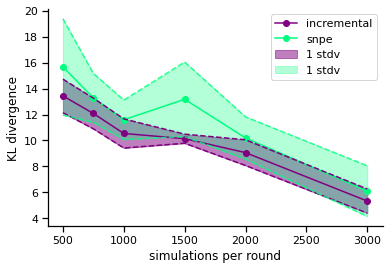

In [48]:
sns.set_context('notebook')
#sns.set_context('talk')

plt.plot(num_simulations_list, mean_incremental, '-o',label='incremental', color='purple')
plt.plot(num_simulations_list, mean_snpe, '-o', label='snpe', color='springgreen')

plt.plot(num_simulations_list, upper_incremental, '--', color='purple')
plt.plot(num_simulations_list, upper_snpe, '--',  color='springgreen', alpha=0.8)

plt.plot(num_simulations_list, lower_incremental, '--',  color='purple')
plt.plot(num_simulations_list, lower_snpe, '--',  color='springgreen', alpha=0.8)


plt.fill_between(x= num_simulations_list, y1=lower_incremental, y2=upper_incremental, color='purple', alpha=0.5,  label='1 stdv')
plt.fill_between(x= num_simulations_list, y1=lower_snpe, y2=upper_snpe, color='springgreen', alpha=0.3, label='1 stdv')


plt.legend()



plt.xlabel('simulations per round')
plt.ylabel('KL divergence')

sns.despine()

